In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from typing import Tuple


# Section 1: Setup


## Load Tickers

In [ ]:
tickers = [
    'AAPL', 
    'MSFT', 
    'GOOGL', 
    ]
years = 5


start_date = datetime.now() - pd.Timedelta(days=365*years)
end_date = datetime.now()

In [ ]:
hist_data = pd.DataFrame()

for ticker in tickers:
    hist_data[ticker] = yf.download(ticker, start="2020-01-01", end="2024-12-01")['Adj Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
display(hist_data.head())

,AAPL,MSFT,GOOGL
Date,,,
2020-01-02,72.796021,153.630692,68.264961
2020-01-03,72.088280,151.717728,67.907852
2020-01-06,72.662712,152.109909,69.717865
2020-01-07,72.320992,150.722977,69.583206
2020-01-08,73.484352,153.123749,70.078476


## Calculate Log Returns
$$
\text{Log Returns} = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$



In [6]:
log_returns = np.log(hist_data / hist_data.shift(1))
log_returns.dropna(inplace=True)

display(log_returns.head())


,AAPL,MSFT,GOOGL
Date,,,
2020-01-03,-0.009770,-0.012530,-0.005245
2020-01-06,0.007937,0.002582,0.026305
2020-01-07,-0.004714,-0.009160,-0.001933
2020-01-08,0.015958,0.015803,0.007092
2020-01-09,0.021018,0.012416,0.010443


We define a portfolio as $X$ such that:
$$
x_A + x_B + x_C = 1
$$

The return of the portfolio is then:

$$
\mu_{p,x} = E[R_{p,x}] = x_A \mu_A + x_B \mu_B + x_C \mu_C
$$

And the variance of the portfolio is:

$$
\sigma_{p,x}^2 = \text{Var}[R_{p,x}] = x_A^2 \sigma_A^2 + x_B^2 \sigma_B^2 + x_C^2 \sigma_C^2 + 2 x_A x_B \sigma_{AB} + 2 x_A x_C \sigma_{AC} + 2 x_B x_C \sigma_{BC}
$$

## Finding Expected Returns (mean)
$$E[\mathbf{R}] = E \left[ \begin{pmatrix} R_A \\ R_B \\ R_C \end{pmatrix} \right] = \begin{pmatrix} E[R_A] \\ E[R_B] \\ E[R_C] \end{pmatrix} = \begin{pmatrix} \mu_A \\ \mu_B \\ \mu_C \end{pmatrix} = \mu,$$


In [7]:
expected_returns = pd.DataFrame(log_returns.mean(), columns=['Annual Return']) * 252
display(expected_returns)


,Annual Return
AAPL,0.240948
MSFT,0.206719
GOOGL,0.184760


## Finding Covariance Matrix


 $$\text{var}(\mathbf{R}) = \begin{pmatrix} 
 \text{var}(R_A) & \text{cov}(R_A, R_B) & \text{cov}(R_A, R_C) \\ 
 \text{cov}(R_B, R_A) & \text{var}(R_B) & \text{cov}(R_B, R_C) \\ 
 \text{cov}(R_C, R_A) & \text{cov}(R_C, R_B) & \text{var}(R_C) 
 \end{pmatrix}$$
 
 $$= \begin{pmatrix} 
 \sigma_A^2 & \sigma_{AB} & \sigma_{AC} \\ 
 \sigma_{AB} & \sigma_B^2 & \sigma_{BC} \\ 
 \sigma_{AC} & \sigma_{BC} & \sigma_C^2 
 \end{pmatrix} = \Sigma.$$


In [8]:
cov_matrix = log_returns.cov() * 252
display(cov_matrix)


,AAPL,MSFT,GOOGL
AAPL,0.101462,0.073438,0.067976
MSFT,0.073438,0.094102,0.074917
GOOGL,0.067976,0.074917,0.105434


## Variance of Portfolio

the variance of the portfolio is given by:

$$
\sigma_{p,x}^2 = \mathbf{w}^T \Sigma \mathbf{w}
$$


In [9]:
def calculate_variance(weights: np.ndarray) -> float:
    return np.sqrt(weights.T @ cov_matrix @ weights)


## Expected return of a portfolio

$$
\mu_{p,x} = \mathbf{w}^T \mu
$$


In [10]:
def calculate_expected_return(weights: np.ndarray, returns: np.ndarray) -> float:
    return weights.T @ returns


## Generate 10000 random portfolios and plot the variance vs expected return

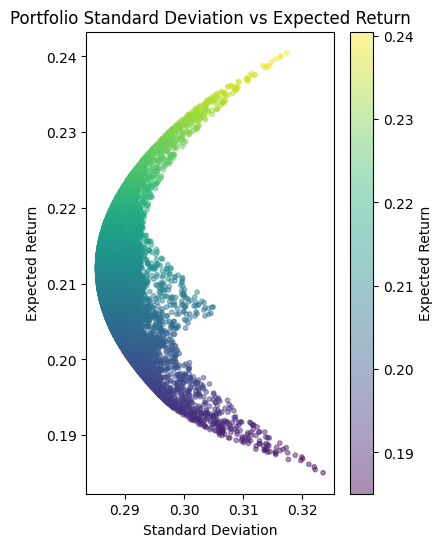

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store variances and portfolio returns
variances = []
portfolio_returns = []

# Convert expected returns to a numpy array
return_array = np.array(expected_returns["Annual Return"])

# Generate 10000 random portfolios
for _ in range(10000):
    # Generate random weights and normalize them
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    
    # Calculate variance and expected return for the portfolio
    variances.append(calculate_variance(weights))
    portfolio_returns.append(calculate_expected_return(weights, return_array))

# Plot the variance vs expected return using a color map
plt.figure(figsize=(4, 6))
scatter = plt.scatter(variances, portfolio_returns, c=portfolio_returns, cmap='viridis', marker='o', s=10, alpha=0.45)
plt.colorbar(scatter, label='Expected Return')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Portfolio Standard Deviation vs Expected Return')

plt.savefig('standard_deviation_vs_expected_return.png', dpi=600, bbox_inches='tight')
plt.show()



# Finding the Global minimum variance portfolio

https://www.youtube.com/watch?v=8mjcnxGMwFo&t=540s

We must find the minimum variance portfolio given the constraints:

$$
\text{min}_{\mathbf{w}} \sigma_{p,x}^2 = w_A^2 \sigma_A^2 + w_B^2 \sigma_B^2 + w_C^2 \sigma_C^2 + 2 w_A w_B \sigma_{AB} + 2 w_A w_C \sigma_{AC} + 2 w_B w_C \sigma_{BC}
$$

s.t.

$$
m_A + m_B + m_C = 1
$$



If we rememebr Langrangian multipliers, we can set up the following system of equations:
$$
\nabla f = \lambda \nabla g
$$
$$
g = 0
$$

let $$f = \sigma_{p,x}^2$$ 
and $$g = m_A + m_B + m_C - 1$$


Then we can define the Lagrangian:
$$
\mathcal{L} = \sigma_{p,x}^2 + \lambda (m_A + m_B + m_C - 1)
$$


Then to optimize, we must solve:
$$ 
\nabla \mathcal{L} = 0
$$



Taking the partial derivatives of the Lagrangian:

$$
\frac{\partial \mathcal{L}}{\partial w_A} = 2w_A\sigma_A^2 + 2w_B\sigma_{AB} + 2w_C\sigma_{AC} + \lambda = 0
$$

$$
\frac{\partial \mathcal{L}}{\partial w_B} = 2w_B\sigma_B^2 + 2w_A\sigma_{AB} + 2w_C\sigma_{BC} + \lambda = 0
$$

$$
\frac{\partial \mathcal{L}}{\partial w_C} = 2w_C\sigma_C^2 + 2w_A\sigma_{AC} + 2w_B\sigma_{BC} + \lambda = 0
$$

$$
\frac{\partial \mathcal{L}}{\partial \lambda} = w_A + w_B + w_C - 1 = 0
$$

This gives us a system of linear equations that can be written in matrix form:

$$
\begin{bmatrix} 
2\sigma_A^2 & 2\sigma_{AB} & 2\sigma_{AC} & 1 \\
2\sigma_{AB} & 2\sigma_B^2 & 2\sigma_{BC} & 1 \\
2\sigma_{AC} & 2\sigma_{BC} & 2\sigma_C^2 & 1 \\
1 & 1 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
w_A \\
w_B \\
w_C \\
\lambda
\end{bmatrix} = 
\begin{bmatrix}
0 \\
0 \\
0 \\
1
\end{bmatrix}
$$


In [25]:
def calculate_portfolio_weights(log_returns):
    sigma = log_returns.cov() * 252
    sigma_block = 2 * sigma

    ones = np.ones(len(sigma))

    A_m = np.vstack([
        np.hstack([sigma_block, ones.reshape(-1, 1)]),
        np.hstack([ones, [0]])
    ])

    b = np.zeros(len(sigma) + 1)
    b[-1] = 1  # Last element is 1

    weights = np.linalg.solve(A_m, b)
    return weights[:-1]

weights = calculate_portfolio_weights(log_returns)
print(weights)


[0.34225367 0.36625223 0.29149409]


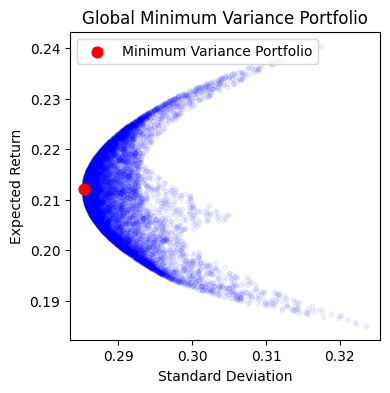

In [33]:
plt.figure(figsize=(4, 4))
plt.scatter(variances, portfolio_returns, c='blue', marker='o', s=10, alpha=0.05)

# Calculate variance and return for the minimum variance portfolio
min_var_portfolio_variance = np.sqrt(weights @ cov_matrix @ weights) 
min_var_portfolio_return = np.dot(weights, expected_returns["Annual Return"])

# Plot the minimum variance portfolio point
plt.scatter(min_var_portfolio_variance, min_var_portfolio_return, 
           c='red', marker='o', s=60, label='Minimum Variance Portfolio')
plt.legend()


plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Global Minimum Variance Portfolio')
plt.savefig('global_minimum_variance_portfolio.png', dpi=600, bbox_inches='tight')
plt.show()



# Finding the optimal portfolio (the efficient frontier)

The efficient frontier represents portfolios that maximize expected return for a given level of risk.
Mathematically, we want to solve:

$$
\text{max } \muₚ = x'μ
$$


subject to:
$$
\sigma_p^2 = \mathbf{x}' \Sigma \mathbf{x} \text{ (target variance)}
$$
$$
x'1 = 1 \text{ (weights sum to 1)}
$$

where:
$$
\mathbf{x} = \text{vector of portfolio weights}
$$
$$
\mu = \text{vector of expected returns}
$$
$$
\Sigma = \text{covariance matrix}
$$
$$
\sigma_p^2 = \text{target portfolio variance level}
$$


Markowitz's also has a dual-problem to this. That is rather than maximizing return for a given level of risk, we can minimize risk for a given level of return. The above problem then becomes a minimization problem.


$$
\text{min } \sigma_p^2 = \mathbf{x}' \Sigma \mathbf{x}
$$

subject to:

$$
\mathbf{x}' \mu = \mu_p
$$
$$
\mathbf{x}' 1 = 1
$$

The lagrangian now holds two multipliers, one for the return constraint and one for the weight constraint.

$$
\mathcal{L}(x, \lambda_1, \lambda_2) = \mathbf{x}' \Sigma \mathbf{x} + \lambda_1 (\mathbf{x}' \mu - \mu_p) + \lambda_2 (1 - \mathbf{x}' 1)
$$


$$\boxed{

\begin{align*}
\frac{\partial \mathcal{L}(x, \lambda_1, \lambda_2)}{\partial \mathbf{x}} &= 2\Sigma \mathbf{x} + \lambda_1 \mu + \lambda_2 \mathbf{1} = 0, \\
\frac{\partial \mathcal{L}(x, \lambda_1, \lambda_2)}{\partial \lambda_1} &= \mathbf{x}' \mu - \mu_p = 0, \\
\frac{\partial \mathcal{L}(x, \lambda_1, \lambda_2)}{\partial \lambda_2} &= \mathbf{x}' \mathbf{1} - 1 = 0.
\end{align*}

}$$

We are then given a linear system, which we are able to solve:

$$
\begin{bmatrix} 
2\Sigma & \mu & \mathbf{1} \\
\mu' & 0 & 0 \\
1' & 0 & 0
\end{bmatrix}
\begin{bmatrix}
x \\
\lambda_1 \\
\lambda_2
\end{bmatrix} = 
\begin{bmatrix}
0 \\
\mu_p \\
1
\end{bmatrix}
$$


In [14]:
def calculate_efficient_portfolio(target_return: float) -> np.ndarray:
    sigma = 2 * (log_returns.cov() * 252)
    ones = np.ones(sigma.shape[0]) 
    mu = np.array(expected_returns["Annual Return"])

    A = np.block([
        [sigma, mu.reshape(-1,1), ones.reshape(-1,1)],
        [mu.reshape(1,-1), 0, 0],
        [ones.reshape(1,-1), 0, 0]
    ])

    b = np.concatenate([np.zeros(sigma.shape[0]), [target_return, 1]])

    solution = np.linalg.solve(A, b)
    return solution[:-2]

It can be shown that all portfolios on the efficient frontier are linear combinations of any two minimum variance portfolios.

Let $\alpha$ be any constant and define the portfolio $\mathbf{z}$ as a linear combination of portfolios $\mathbf{x}$ and $\mathbf{y}$:

$$
\mathbf{z} = \alpha \cdot \mathbf{x} + (1 - \alpha) \cdot \mathbf{y}
$$

which results in:

$$
\mathbf{z} = 
\begin{pmatrix}
\alpha x_A + (1 - \alpha) y_A \\
\alpha x_B + (1 - \alpha) y_B \\
\alpha x_C + (1 - \alpha) y_C
\end{pmatrix}
$$

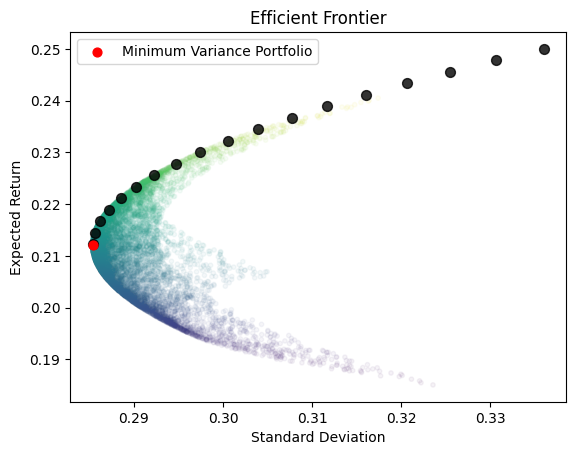

In [42]:
alpha = np.linspace(0, 1, 100)


target_x = .25
target_y = 0.03

x_portfolio = calculate_efficient_portfolio(target_x)
y_portfolio = calculate_efficient_portfolio(target_y)

frontier_weights = []

for _ in alpha:
    alpha_portfolio = _ * x_portfolio + (1 - _) * y_portfolio
    frontier_weights.append(alpha_portfolio)

frontier_expected_return = []
frontier_variance = []

for _ in frontier_weights:
    variance = calculate_variance(_)
    expected_return = calculate_expected_return(_, return_array)
    if expected_return > min_var_portfolio_return:
        frontier_expected_return.append(expected_return)
        frontier_variance.append(variance)


# plot the efficient frontier

plt.scatter(frontier_variance, frontier_expected_return, c='#000000', marker='o', s=50, alpha=0.8, zorder=2)

# plot the randomm portfolios
plt.scatter(variances, portfolio_returns, c=portfolio_returns, cmap='viridis', marker='o', s=10, alpha=0.05)

# plot the minimum variance portfolio
plt.scatter(min_var_portfolio_variance, min_var_portfolio_return, c='red', marker='o', s=40, label='Minimum Variance Portfolio', zorder=3)

plt.legend()
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.savefig('efficient_frontier.png', dpi=600, bbox_inches='tight')
plt.show()




## Computing the Tangency Portfolio

The tangency portfolio is the portfolio of risky assets that has the highest
Sharpe ratio. it is denoted
 
 $$
 \mathbf{t} = (t_A, t_B, t_C)
 $$
 
 and it solves the problem:
 
 $$
 \text{max } \frac{\mathbf{t}' \mu - r_f}{\sqrt{\mathbf{t}' \Sigma \mathbf{t}}} = \frac{\mu_p - r_f}{\sigma_p} \text{ s.t. } \mathbf{t}' \mathbf{1} = 1, \mathbf{t} \geq 0
 $$
 
 The Lagrangian is:
 
 $$
 \mathcal{L} = \frac{\mathbf{t}' \mu - r_f}{\sqrt{\mathbf{t}' \Sigma \mathbf{t}}} + \lambda (\mathbf{t}' \mathbf{1} - 1) + \sum_{i} \gamma_i t_i
 $$
 
 It can be shown that:
 
 $$
 \mathbf{t} = \frac{\Sigma^{-1}(\mu - r_f \cdot \mathbf{1})}{\mathbf{1}'\Sigma^{-1}(\mu - r_f \cdot \mathbf{1})}
 $$
 
 with the constraint $\mathbf{t} \geq 0$ ensuring no negative weights.







In [43]:
risk_free_rate = 0.04
# get the inverse of the covariance matrix
covariance_matrix_inverse = np.linalg.inv(cov_matrix)

# get the tangency portfolio
ones_vector = np.ones(len(return_array))
adjusted_returns = return_array - risk_free_rate

numerator = covariance_matrix_inverse @ adjusted_returns
denominator = ones_vector @ covariance_matrix_inverse @ adjusted_returns

tangency_portfolio = numerator / denominator
print(tangency_portfolio)
calculate_expected_return(tangency_portfolio, return_array)

sharpe_ratio = (calculate_expected_return(tangency_portfolio, return_array) - risk_free_rate) / calculate_variance(tangency_portfolio)
print(sharpe_ratio)



[ 0.76705881  0.26788599 -0.0349448 ]
0.6397436806447179


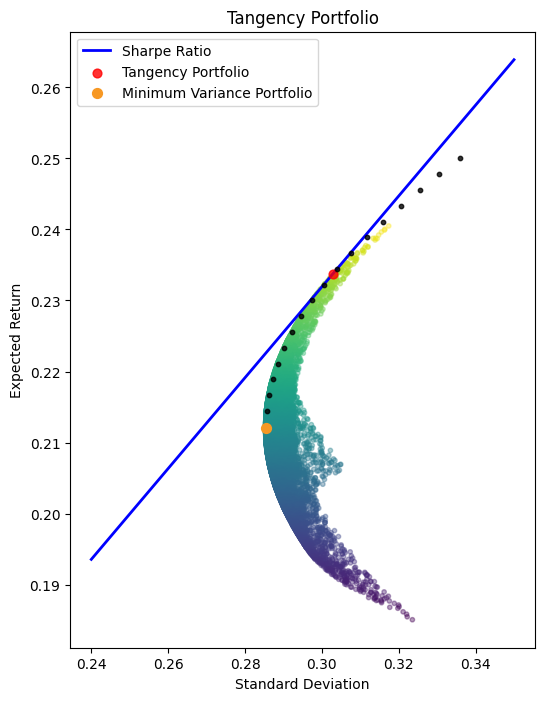

In [47]:
plt.figure(figsize=(6, 8))
# Define x values for the Sharpe Ratio line
sr_x_values = np.linspace(0.24, 0.35, 10)

# Calculate y values for the Sharpe Ratio line
sr_y_values = risk_free_rate + sharpe_ratio * sr_x_values

# Plot the Sharpe Ratio line
plt.plot(sr_x_values, sr_y_values, color='blue', label='Sharpe Ratio', linewidth=2)

# Plot the Tangency Portfolio
plt.scatter(
    calculate_variance(tangency_portfolio),
    calculate_expected_return(tangency_portfolio, return_array),
    color='red',
    label='Tangency Portfolio',
    marker='o',
    s=40,
    alpha=0.8,
    zorder=2
)

# Plot the Efficient Frontier
plt.scatter(
    frontier_variance,
    frontier_expected_return,
    color='black',
    marker='o',
    s=10,
    alpha=0.8,
    zorder=2
)

# Plot the random portfolios
plt.scatter(
    variances,
    portfolio_returns,
    c=portfolio_returns,
    cmap='viridis',
    marker='o',
    s=10,
    alpha=0.4
)

# Plot the Minimum Variance Portfolio
plt.scatter(
    min_var_portfolio_variance,
    min_var_portfolio_return,
    color='#F79824',
    marker='o',
    s=50,
    label='Minimum Variance Portfolio',
    zorder=3
)
# Add legend, labels, and title
plt.legend()
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.title('Tangency Portfolio')
plt.savefig('tangency_portfolio.png', dpi=600, bbox_inches='tight')
plt.show()

https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf

https://scholarship.richmond.edu/cgi/viewcontent.cgi?article=1018&context=finance-faculty-publications

https://examples.holoviz.org/gallery/portfolio_optimizer/portfolio_optimizer.html

https://www.cis.upenn.edu/~mkearns/finread/intuition.pdf


